In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

from scipy.io import loadmat
import sys
import numpy as np
from numpy.fft import *
from scipy.sparse import *

In [2]:
# quickly load all the variables from mat file

thismodule = sys.modules[__name__]
val_dict = loadmat('data/variable_vals_inside_linear_reassignment.mat')

for name, value in val_dict.items():
    if name[:2] == '__': continue
    setattr(thismodule, name, val_dict[name])

In [3]:
N_p = [[x.size]]

In [4]:
assert N_p == N

In [5]:
xf_p = fftn(x)

In [6]:
np.any(xf_p == xf)

True

In [7]:
HT_p = np.ceil(N_p/tdeci)

In [8]:
assert HT_p == HT

In [9]:
noct = noct.astype(np.float32)

In [10]:
HF_p = np.ceil(-noct*np.log2(minf/maxf)+1)

In [11]:
assert HF_p == HF

In [12]:
f_p = np.arange(0, N) / N

In [13]:
assert np.all(f_p == f)

In [14]:
histo = csc_matrix((HT[0][0], HF[0][0]))
histc = csc_matrix((HT[0][0], HF[0][0]))

allt = np.zeros((1,0))
allf = np.zeros((1,0))
alle = np.zeros((1,0))
allc = np.zeros((1,0))

minf = minf.astype(np.float32)
maxf = maxf.astype(np.float32)
over = over.astype(np.float32)
noct = noct.astype(np.float32)

# here I manually stepped through the for loop in Matlab and implemented and verified correctness after each step

for log2f0 in np.arange(0, HF.astype(np.float32)*over):
    f0 = minf*2**(log2f0/over/noct)
    sigma = f0/(2*np.pi*q)
    gau = np.exp(-(f-f0)**2 / (2*sigma**2))
    gde = -1/sigma**1 * (f-f0) * gau
    
    xi = ifftn(gau.T * xf)
    eta = ifftn(gde.T * xf)
    mp = eta / xi
    ener = abs(xi)**2
    
    tins = np.arange(1, N+1).reshape(-1, 1) + np.imag(mp)/(2*np.pi*sigma)
    fins = f0 - np.real(mp)*sigma;
    
    mask = (abs(mp)<lint) & (fins < maxf) & (fins>minf) & (tins>=1) & (tins<N)
    tins = tins[mask]
    fins = fins[mask]
    ener = ener[mask]
    
    itins = np.round(tins/tdeci+0.5)               
    ifins = np.round(-noct*np.log2(fins/maxf)+1)
    
    allt = np.hstack((allt, itins))
    allf = np.hstack((allf, ifins))
    alle = np.hstack((alle, ener.reshape(1, -1)))
    allc = np.hstack((allc, 0*itins+1))
    
    if(len(allt)>MAXL):
        histo = histo + csc_matrix(
            (
                alle[0],
                (allt[0].astype(np.int) - 1, allf[0].astype(np.int) - 1)
            ),
            (HT[0][0],HF[0][0])
        )

        histc = histc + csc_matrix(
            (
                allc[0],
                (allt[0].astype(np.int) - 1, allf[0].astype(np.int) - 1)
            ),
            (HT[0][0],HF[0][0])
        )
        allt = []
        allf = []
        alle = []
        allc = []
        
histo = histo + csc_matrix(
    (
        alle[0],
        (allt[0].astype(np.int) - 1, allf[0].astype(np.int) - 1)
    ),
    (HT[0][0],HF[0][0])
)
    
histc = histc + csc_matrix(
    (
        allc[0],
        (allt[0].astype(np.int) - 1, allf[0].astype(np.int) - 1)
    ),
    (HT[0][0],HF[0][0])
)

mm = csc_matrix.max(histc)
histo[histc < np.sqrt(mm)] = 0
histo.eliminate_zeros()

/home/radek/anaconda3/envs/fastai/lib/python3.7/site-packages/scipy/sparse/compressed.py:287: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/home/radek/anaconda3/envs/fastai/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


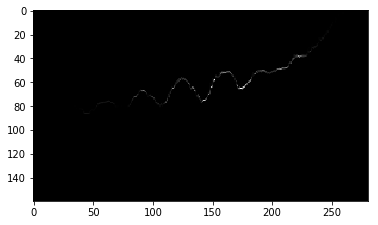

In [15]:
plt.imshow(histo.todense().T, cmap=plt.cm.gray)